In [18]:
% matplotlib inline
from myst_nb import glue

(chap-pythongis)=
# GIS in Python

Manche mag das jetzt überraschen, andere haben es vielleicht schon gemerkt: Mit **GIS** hatte unseres bisheriges Wirken in Python eigentlich wenig zu tun. Unsere Zeckenstiche haben zwar x/y-Koordinaten, aber diese haben wir bisher gleich behandlet wie alle anderen Spalten.

Anders gesagt: *Wir* wissen ja, dass mit den Spalten `x` und `y` Koordinaten in der Schweiz gemeint sind, Python hingegen wusste das bisher (noch) nicht. Der konkrete Raumbezug fehlt also noch, und das wird irgendwann problematisch: Denn bald wollen wir pro simulierten Zeckenstich ermitteln, ob er sich im Wald befindet oder nicht. Das ist eine explizit räumliche Abfrage, welche nur mit explizit räumlichen Geodaten beantwortet werden kann. 

Was wir später mit den simulierten Zeckenstiche machen wollen, spielen wir an dieser Stelle mit den Zeckenstichreports (`zeckenstiche.csv`) durch.

In [1]:
# Unsere Zeckenstiche hatten wir auf folgende Weise importiert:
    
import pandas as pd
zeckenstiche = pd.read_csv("zeckenstiche.csv")
zeckenstiche

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


,ID,accuracy,x,y
0,2550,439.128951,2681116,1250648
1,10437,301.748542,2681092,1250672
2,9174,301.748542,2681128,1250683
3,8773,301.748542,2681111,1250683
4,2764,301.748529,2681131,1250692
5,2513,301.748529,2681171,1250711
6,9185,301.748542,2681107,1250712
7,28521,301.748542,2681124,1250720
8,26745,301.748542,2681117,1250725
9,27391,301.748542,2681138,1250725


### von Dataframes zu *Geo*DataFrames

Glücklicherweise können wir unsere Zeckenstich-*Dataframe* mit nur einem Zusatzmodul und wenigen Zeilen code in eine **räumliche** *DataFrame* konvertieren. Mit dem Modul ***geo**pandas* erstellen wir aus unserer *pandas DataFrame* eine ***geo**pandas **Geo**DataFrame*. Mit dieser Erweiterung erhält die *DataFrame* im Wesentlichen (a) eine Zusatzspalte `geometry` mit der Geometrie als räumliches Objekt und (b) ein Attribut `crs` welches das Koordinatensystem der Geometriespalte enthält. 

Beide dieser Bestandteile müssen wir bei der Erstellung der *GeoDataFrame* festlegen. Nachstehend seht ihr, wie ihr dies bei den Zeckenstichen machen könnt, was diese Bestandteile genau bedeuten seht ihr in den {ref}`chap-pythongis-datenstruktur` und {ref}`chap-pythongis-crs`. 


In [19]:
import geopandas as gpd

zeckenstiche_gpd = gpd.GeoDataFrame(zeckenstiche, # die Basis-DataFrame / die "Attributtabelle"
                                    # die Geometrie Spalte:
                                    geometry=gpd.points_from_xy(zeckenstiche['x'], zeckenstiche['y']),
                                    crs = 2056) # EPSG Code des Koorinatensystem
zeckenstiche_gpd

,ID,accuracy,x,y,geometry
0,2550,439.128951,2681116,1250648,POINT (2681116.000 1250648.000)
1,10437,301.748542,2681092,1250672,POINT (2681092.000 1250672.000)
2,9174,301.748542,2681128,1250683,POINT (2681128.000 1250683.000)
3,8773,301.748542,2681111,1250683,POINT (2681111.000 1250683.000)
4,2764,301.748529,2681131,1250692,POINT (2681131.000 1250692.000)
5,2513,301.748529,2681171,1250711,POINT (2681171.000 1250711.000)
6,9185,301.748542,2681107,1250712,POINT (2681107.000 1250712.000)
7,28521,301.748542,2681124,1250720,POINT (2681124.000 1250720.000)
8,26745,301.748542,2681117,1250725,POINT (2681117.000 1250725.000)
9,27391,301.748542,2681138,1250725,POINT (2681138.000 1250725.000)


(chap-datenstruktur)=
### Aufbau von GeoDataFrames

Mit `geometry = ` haben wir die Geometriespalte der *GeoDataFrame* festgelegt. Bei unseren Zeckenstichdaten ist die Geometrie sehr simpel: Sie besteht aus Punkt-Objekte die sich wiederum aus den x- und y-Koordinaten zusammensetzen. Um x/y-Koordinaten in Punktgeometrien zu konvertieren gibt es in Geopandas die Funktion `points_from_xy`. Diese verwende ich im obigen Code um die Punkt-Objekte zu erstellen.

An dieser Stelle ist es wichtig, die drei Hierarchiestufen von GeoDataFrames zu kären. Von "unten" nach "oben" erläutert gibt es folgende Stufen:

- **Geometry**: Einzelne Objekte [^shapely] der folgenden Typen
  - Points / Multipoint [^multi]
  - Linestring / Multilinestring [^multi]
  - Polygon / Multipolygon [^multi]
- **GeoSeries**: Eine Serie von Geometrien, gleichbedeutend wie eine **Spalte** in einer Tabelle
- **GeoDataFrame**: Eine Tabelle, welche über eine Geometrie-Spalte (GeoSeries) verfügt

```{figure} Geopandas_types.jpg
---
name: geopandas-types
---
Die drei Hierarchien in Geopandas: Eine *GeoDataFrame* verfügt immer über eine Geometrie-Spalte, welche sich eine *GeoSeries* nennt. Diese wiederum besteht aus Einzelgeometrien, sogenannten *Geometries*.
```

[^shapely]: Die Geometrien in Geopandas sind eigentlich Objekte vom Modul [*Shapely*](https://pypi.org/project/Shapely/). Shapely wiederum ist ein Python Modul, welches mit *Geopandas* mit-installiert und mit-importiert wird.

(chap-pythongis-crs)=
### Koordinatensystem

Mit `crs = ` wird das Koordiantensystem (engl. **C**oordinate **R**eference **S**ystem) unseres Datensatzes festgelegt. Das Koordinatensystem gibt unseren x/y-Zahlenwerten einen konkreten Raumbezug auf dem Planeten und macht aus ihnen Koordiaten *in der Schweiz*. Wie lautet aber das "Koordinatensystem" unserer Daten? 

Im Prinzip weiss diese Information nur derjenige, der die Daten erstellt hat. Man man das Koordinatensytem aber auch anhand der Koordinaten erahnen: Es handelt sich in unserem Fall um Werte im Bereich von 2.6 Mio auf der einen und 1.2 Mio auf der anderen Achse. Da wir wissen das die Daten aus der Schweiz stammen kann man mit etwas Erfahrung sagen, dass es sich um Daten im neuen Schweizer Koordinatensystem [CH1903+ / LV95](https://epsg.io/2056) handeln muss. Der EPSG Code dieses Koordinatensystems lautet 2056 und diesen Code können wir in der Funktion `gpd.GeoDataFrame` nutzuen, um das Korrekte Koordinatensystem zu zuweisen.

In [15]:
# Das Attribut `crs` wurde aufgrund vom EPSG Code richtig erkannt:
zeckenstiche_gpd.crs.name

'CH1903+ / LV95'

(chappythongisformate)=
### Geodatenformate

Das Einlesen von CSV und die Konvertierung von *DataFrame* zu *GeoDataFrame* hat bei den Zeckenstichen zwar gut funktioniert, es ist aber auch etwas umständlich jedes Mal die `geometry` Spalte und das `crs` zu setzen. CSVs eignen sich nicht besonders gut für das speichern von Geodaten, deshalb gibt es auch spezifische Geodaten-Datenformate. Bei diesen Datenformaten werden `geometry` und `crs` automatisch abgespeichert. 

Ihr seid im Studium mit solchen Datenformate bereits in Kontakt gekommen, sicher kennt ihr ESRI's *File Geodatabases*/*Feature Classes*  sowie *Shapefiles*. Dies sind häufig genutzte Formate, aber leider nicht offen, und gerade Shapefiles haben viele Tücken (siehe [switchfromshapefile.org](http://switchfromshapefile.org/)). Es gibt dafür ganz tolle Alternativen, beispielsweise *Geopackages* (nicht zu verwechseln mit ArcGIS Pro Packages!). Mit nachstehendem Befehl können wir `zeckenstiche_gpd` als Geopackage abspeichern.

```python
zeckenstiche_gpd.to_file("zeckenstiche.gpkg", driver = "GPKG")
```
Das File "zeckenstiche.gpkg" befindet sich nun in meiner *Working Directory* und ich kann sie mit `gpd.read_file("zeckenstiche.gpkg")` wieder einlesen. Im Unterschied zu vorher musst ich nun `geometry` und `crs` nicht mehr zuweisen, diese sind im Geopackage abgespeichert worden. Das Geopackage kann ich nun auch mit ArcGIS öffnen, wenn ich die Punkte interaktiv explorieren möchte.

Im Block "Datenqualität und Unsicherheit" habt ihr mit dem Wald Datensatz gearbeitet. Ich habe diesen als *Geopackage* exportiert und kann ihn wie im nachstehend Codeblock ersichtlich einlesen und visualisieren. 



In [16]:
import geopandas as gpd

wald = gpd.read_file("wald.gpkg") # <- importiert das File "wald.gpkg"

wald

,Shape_Area,Wald_text,geometry
0,2.380876e+08,nein,MULTIPOLYGON Z (((2692100.000 1256542.253 276....
1,7.963237e+07,ja,MULTIPOLYGON Z (((2689962.355 1245335.250 644....


Es handelt sich also um einen Datensatz mit nur zwei Zeilen, aber mehreren Polygonen pro Zeile (das macht es zu einem ***Multi**polygon*[^multi]). Mit `plot` können wir diesen Datensatz einfach visualisieren.


[^multi]: Der Unterschied zwischen Point und *Multi*point, Linesstring und *Multi*linestring und Polygon *Multi*polyon ist folgendermassen: Typischerweise hat jedes Attribut *eine* Geometrie. Zum Beispiel hat jede Zeckenstichmeldung eine ID, eine Ungenauigkeitsangabe und eben *eine* Punkgeometrie. Somit handelt es sich bei diesem Datensatz um einen einfach *Point* Datensatz. Wenn pro Attribut mehrere Geometrien zugewiesen sind handelt es sich um ein *Multi*point Objekt.

<AxesSubplot:>

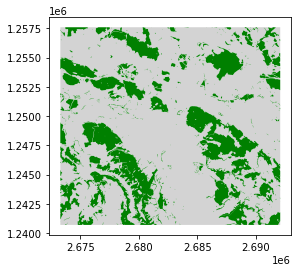

In [18]:
wald.plot(color = ["Lightgrey","Green"])

KOMMENTAR:

Aktuell wird die bei der Funktion "GeoDataFrame()" die ursprüngliche DataFrame modifiziert. siehe https://github.com/geopandas/geopandas/issues/1179

Das führt zu sehr unangenehmen Nebeneffekten. Zum Beispiel kann die letzte Aufgabe nicht in einem For Loop gelöst werden, wie im Commit 1bedada versucht wurde (https://github.com/ratnanil/codingingis/commit/1bedada0c73fcb25716f8442c2d6ed86fc372713)